In [2]:
import numpy as np
import wfdb
from os import path
import os
import matplotlib.pyplot as plt

%matplotlib inline

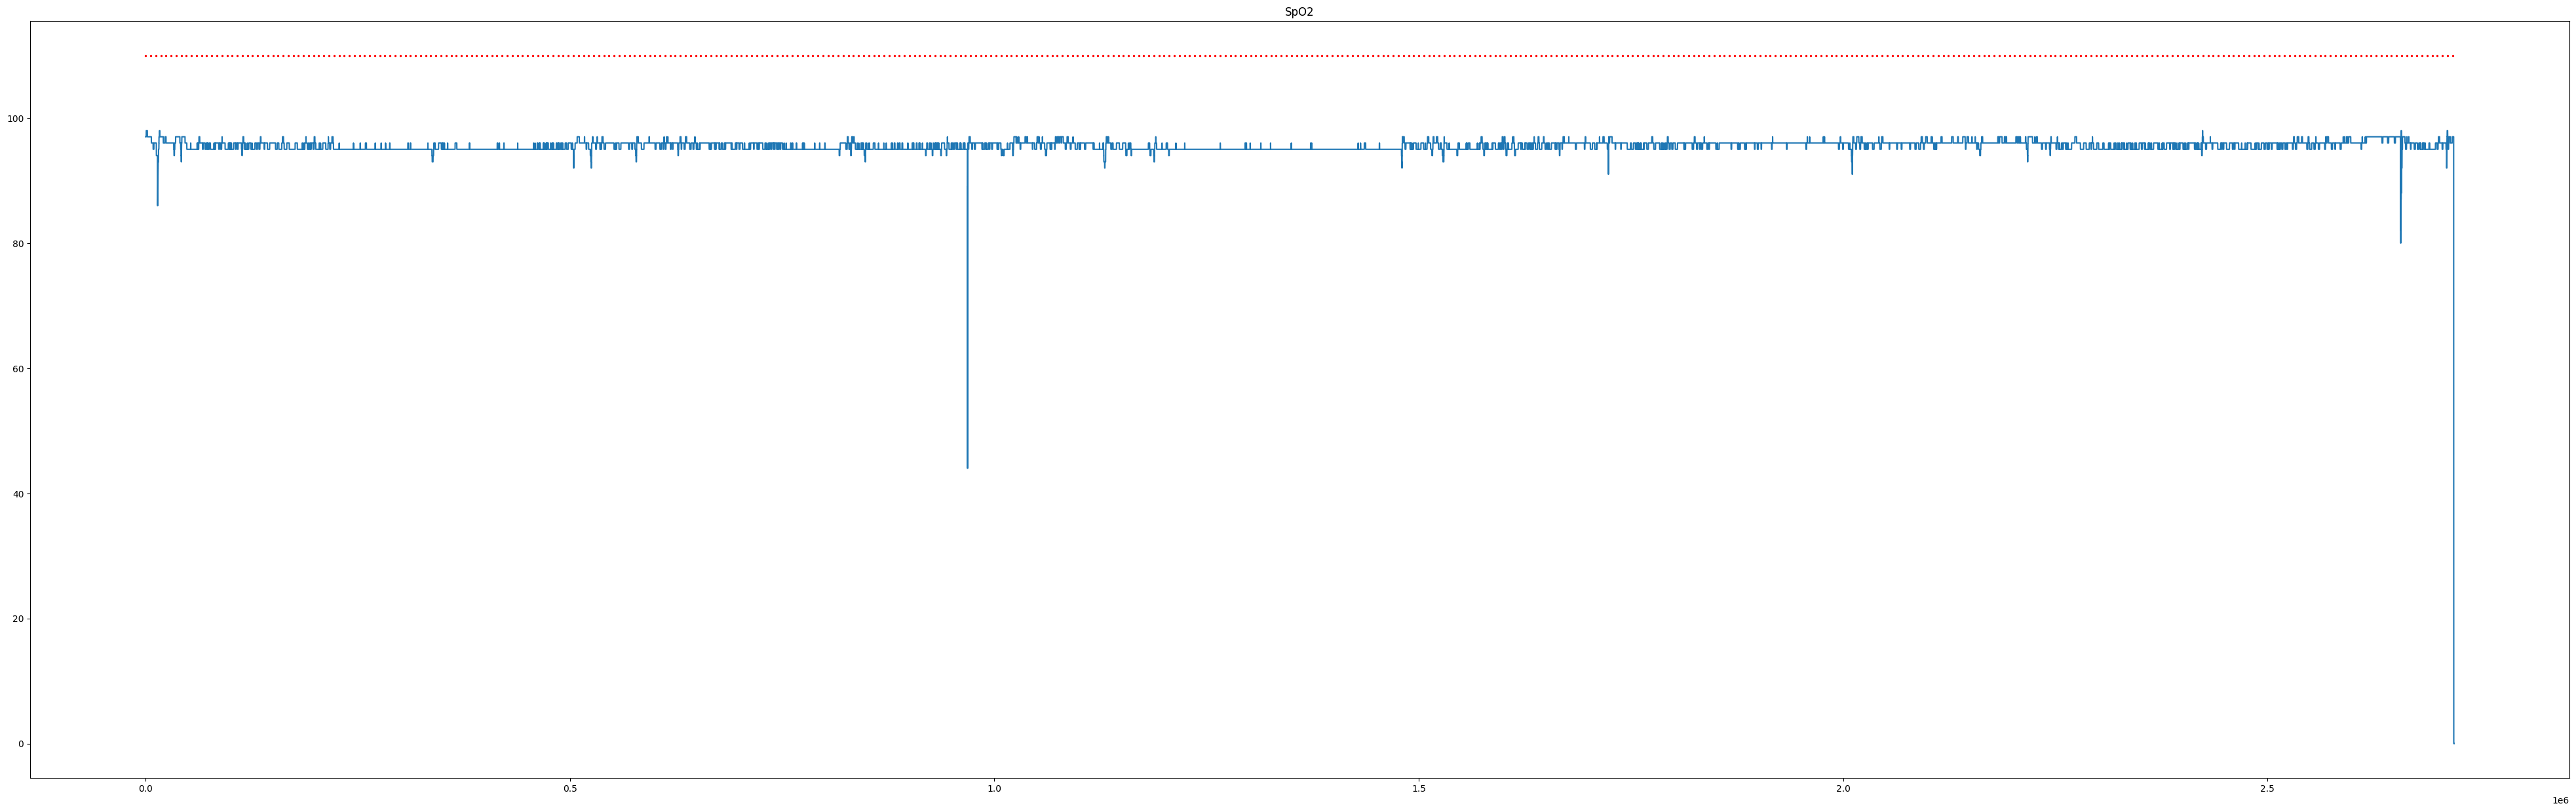

In [8]:
records = ["a01r", "a02r", "a03r", "a04r", "b01r", "c01r", "c03r"]

rec = wfdb.rdsamp(path.join("database", records[6]))
ann = wfdb.rdann(path.join("database", records[6]), extension="apn").symbol
ann = [110 if x == "N" else -1 for x in ann]
info = rec[1]
rec = rec[0].T
plt.figure(figsize=(50, 15))
plt.title("SpO2")
plt.plot(rec[3])
plt.scatter(range(0, len(ann)*6000, 6000), ann, color="r", s=2)
plt.show()